# imports

In [479]:
import pandas as pd
import numpy as np
import heapq as hq
from random import *
import pickle


# input files

In [127]:
# import from library
storage_list = pd.read_pickle(r'storage_list.p')
prob_list = pd.read_pickle(r'prob_list.p')

In [128]:
storage_list

[[100, 1],
 [101, 4],
 [102, 7],
 [103, 3],
 [104, 11],
 [105, 7],
 [106, 4],
 [107, 11],
 [108, 1],
 [109, 7],
 [110, 4],
 [111, 2],
 [112, 7],
 [113, 7],
 [114, 4],
 [115, 2],
 [116, 6],
 [117, 7],
 [118, 4],
 [119, 9],
 [120, 5],
 [121, 2],
 [122, 5],
 [123, 5],
 [124, 5],
 [125, 11],
 [126, 7],
 [127, 5],
 [128, 6],
 [129, 6],
 [130, 6],
 [131, 6],
 [132, 2],
 [133, 8],
 [134, 3],
 [135, 7],
 [136, 8],
 [137, 5],
 [138, 1],
 [139, 1]]

In [129]:
prob_list

[[100, 0.004830917874396135],
 [101, 0.014492753623188406],
 [102, 0.033816425120772944],
 [103, 0.014492753623188406],
 [104, 0.05314009661835749],
 [105, 0.028985507246376812],
 [106, 0.01932367149758454],
 [107, 0.05314009661835749],
 [108, 0.004830917874396135],
 [109, 0.033816425120772944],
 [110, 0.014492753623188406],
 [111, 0.004830917874396135],
 [112, 0.043478260869565216],
 [113, 0.028985507246376812],
 [114, 0.01932367149758454],
 [115, 0.00966183574879227],
 [116, 0.024154589371980676],
 [117, 0.033816425120772944],
 [118, 0.014492753623188406],
 [119, 0.04830917874396135],
 [120, 0.028985507246376812],
 [121, 0.00966183574879227],
 [122, 0.01932367149758454],
 [123, 0.00966183574879227],
 [124, 0.014492753623188406],
 [125, 0.03864734299516908],
 [126, 0.043478260869565216],
 [127, 0.01932367149758454],
 [128, 0.033816425120772944],
 [129, 0.033816425120772944],
 [130, 0.028985507246376812],
 [131, 0.028985507246376812],
 [132, 0.00966183574879227],
 [133, 0.0483091787439

## organize data

In [452]:
# covert to dataframe
item_ids = []
quantity_to_store=[]
item_prob=[]

for i in range(len(storage_list)):
    item_ids.append(storage_list[i][0])
    quantity_to_store.append(storage_list[i][1])
    item_prob.append(prob_list[i][1])
    
items = pd.DataFrame({'item': item_ids,'item_prob':item_prob,'quantity_to_allocate':quantity_to_store})

# add expected value column
items['expected_value_in_order'] = items.loc[:,'item_prob']*40

items

,item,item_prob,quantity_to_allocate,expected_value_in_order
0,100,0.004831,1,0.193237
1,101,0.014493,4,0.579710
2,102,0.033816,7,1.352657
3,103,0.014493,3,0.579710
4,104,0.053140,11,2.125604
5,105,0.028986,7,1.159420
6,106,0.019324,4,0.772947
7,107,0.053140,11,2.125604
8,108,0.004831,1,0.193237
9,109,0.033816,7,1.352657


## explore data to set priorities

### numeric exploration

In [453]:
explore = items.copy()
explore.loc[(explore['expected_value_in_order']>0) & (explore['expected_value_in_order']<=0.5) ,'bin'] = '0.0-0.5'
explore.loc[(explore['expected_value_in_order']>0.5) & (explore['expected_value_in_order']<=1) ,'bin'] = '0.5-1.0'
explore.loc[(explore['expected_value_in_order']>1) & (explore['expected_value_in_order']<=1.5) ,'bin'] = '1.0-1.5'
explore.loc[(explore['expected_value_in_order']>1.5) & (explore['expected_value_in_order']<=2) ,'bin'] = '1.5-2.0'
explore.loc[(explore['expected_value_in_order']>2) ,'bin'] = '>2.0'

num_unique_items = explore.copy()
num_unique_items = num_unique_items.loc[:,['bin','item']]
num_unique_items = num_unique_items.groupby('bin', as_index=False).count()

quantity_items = explore.copy()
quantity_items = quantity_items.loc[:,['bin','quantity_to_allocate']]
quantity_items = quantity_items.groupby('bin', as_index=False).sum()

In [454]:
num_unique_items.head(10)

,bin,item
0,0.0-0.5,9
1,0.5-1.0,12
2,1.0-1.5,11
3,1.5-2.0,6
4,>2.0,2


In [455]:
quantity_items.head(10)

,bin,quantity_to_allocate
0,0.0-0.5,17
1,0.5-1.0,52
2,1.0-1.5,71
3,1.5-2.0,50
4,>2.0,22


### visual exploration

In [456]:
#sort by expected value column
items.sort_values('expected_value_in_order', ascending=True)

,item,item_prob,quantity_to_allocate,expected_value_in_order
0,100,0.004831,1,0.193237
38,138,0.004831,1,0.193237
11,111,0.004831,2,0.193237
8,108,0.004831,1,0.193237
39,139,0.004831,1,0.193237
23,123,0.009662,5,0.386473
32,132,0.009662,2,0.386473
21,121,0.009662,2,0.386473
15,115,0.009662,2,0.386473
24,124,0.014493,5,0.579710


<AxesSubplot:xlabel='item', ylabel='expected_value_in_order'>

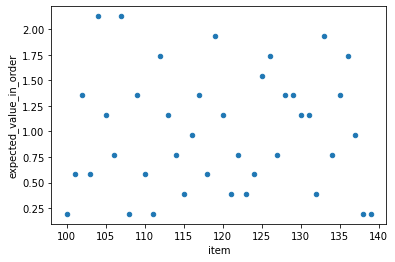

In [457]:
items.plot.scatter(x = 'item', y = 'expected_value_in_order', colormap='viridis')

<AxesSubplot:>

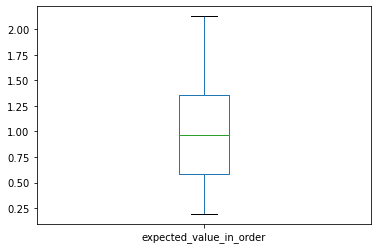

In [458]:
items.plot.box(x = 'item', y = 'expected_value_in_order')

In [459]:
print('expected_value_in_order percentile 0.02 - %s' %items['expected_value_in_order'].quantile(0.02))
print('expected_value_in_order percentile 0.05 - %s' %items['expected_value_in_order'].quantile(0.05))
print('expected_value_in_order percentile 0.1 - %s' %items['expected_value_in_order'].quantile(0.1))

expected_value_in_order percentile 0.02 - 0.1932367149758454
expected_value_in_order percentile 0.05 - 0.1932367149758454
expected_value_in_order percentile 0.1 - 0.1932367149758454


## organize data after exploration 

In [460]:
items.loc[(items['expected_value_in_order']>0) & (items['expected_value_in_order']<=0.5) ,'priority'] = 5
items.loc[(items['expected_value_in_order']>0.5) & (items['expected_value_in_order']<=1) ,'priority'] = 4
items.loc[(items['expected_value_in_order']>1) & (items['expected_value_in_order']<=1.5) ,'priority'] = 3
items.loc[(items['expected_value_in_order']>1.5) & (items['expected_value_in_order']<=2) ,'priority'] = 2
items.loc[(items['expected_value_in_order']>2) ,'priority'] = 1
items['priority'] = items['priority'].astype(int)

In [461]:
items

,item,item_prob,quantity_to_allocate,expected_value_in_order,priority
0,100,0.004831,1,0.193237,5
1,101,0.014493,4,0.579710,4
2,102,0.033816,7,1.352657,3
3,103,0.014493,3,0.579710,4
4,104,0.053140,11,2.125604,1
5,105,0.028986,7,1.159420,3
6,106,0.019324,4,0.772947,4
7,107,0.053140,11,2.125604,1
8,108,0.004831,1,0.193237,5
9,109,0.033816,7,1.352657,3


# Allocation Algo

In [521]:
class Allocation():
    
    def __init__(self,items,floors,cells):
        self.items = items
        self.floors = floors
        self.cells = cells
        self.priorities = items['priority'].unique().tolist()
        self.warehouse = np.zeros(shape=(floors,cells,3)).astype(int)
        self.warehouse_output = np.zeros(shape=(floors,cells,2)).astype(int) #####
        self.available_cells = []
        self.allocation_result = {}
        self.items_in_floor = [[],[],[],[],[],[],[],[]]
   
    def setup(self):
        
        # sort prioirities
        self.priorities.sort()
        # debug - print(self.priorities)
                
        # set prioritization for each cell
        for i in range(self.floors):
            for j in range(self.cells):
                for k in range(2):
                    # diagonally located cells have the same prioritization.
                    self.warehouse[i][j][2] = i+j
                    self.available_cells.append((i+j,[i,j,k]))
                    
        
        # sort the cells by shortest time, ascending
        self.available_cells.sort()
        #debug - print(self.available_cells)

        # sort items table by expected_value, descending
        self.items = self.items.sort_values('expected_value_in_order', ascending=False)

        # add dymanic quantity to store solumn
        self.items['current_quantity_to_allocate'] = self.items['quantity_to_allocate'].copy()
 
    
    def allocation(self):
        
        # total items to store at any moment
        current_items_to_allocate = self.items['current_quantity_to_allocate'].sum()
        

        # as long as there are items to store, countinue.
        while current_items_to_allocate > 0:

            for p in self.priorities:
                # pick items to allocate by current priority
                items_to_allocate = self.items.loc[(self.items['priority']<=p) & (self.items['current_quantity_to_allocate']>0),'item'].tolist()
                #update current amount to allocate
                self.items.loc[(self.items['priority']<=p) & (self.items['current_quantity_to_allocate']>0),'current_quantity_to_allocate'] = self.items.loc[:,'current_quantity_to_allocate']-1

                # debug - print('---------------------%s---------------------' %p)
                # debug - print(items_to_allocate)
                # debug - print(self.available_cells)
                
                #allocate
                for item in items_to_allocate:
                    # get the time of lowest time cell available
                    cell_priority = self.available_cells[0][0]
                    
                    # get the location lowest time cell available
                    cell_location = self.available_cells[0][1]
                    
                    # debug - print(self.available_cells[0])
                    # store the item in the cell
                    self.warehouse[cell_location[0]][cell_location[1]][cell_location[2]] = item
                    self.warehouse_output[cell_location[0]][cell_location[1]][cell_location[2]] = item ###
                    
                    # remove allocated item from items_to_allocate list
                    items_to_allocate = items_to_allocate[1:]
                    # remove taken cell from available_cells list
                    self.available_cells = self.available_cells[1:]
                    
                    # update sanity check dictionary
                    if item in self.allocation_result.keys():
                        self.allocation_result[item]['cell_priorities'].append(cell_priority)
                        self.allocation_result[item]['locations'].append(cell_location)
                    else:
                        self.allocation_result[item] = {'priority': p, 'cell_priorities': [cell_priority], 'locations': [cell_location]}
                    
                    # update floor list
                    self.items_in_floor[cell_location[0]].append((item,cell_location))

                current_items_to_allocate = self.items['current_quantity_to_allocate'].sum()


In [522]:
allocate = Allocation(items,8,16)
allocate.setup()
allocate.allocation()

In [523]:
# sanity check
allocate.items

,item,item_prob,quantity_to_allocate,expected_value_in_order,priority,current_quantity_to_allocate
4,104,0.053140,11,2.125604,1,0
7,107,0.053140,11,2.125604,1,0
33,133,0.048309,8,1.932367,2,0
19,119,0.048309,9,1.932367,2,0
26,126,0.043478,7,1.739130,2,0
12,112,0.043478,7,1.739130,2,0
36,136,0.043478,8,1.739130,2,0
25,125,0.038647,11,1.545894,2,0
35,135,0.033816,7,1.352657,3,0
17,117,0.033816,7,1.352657,3,0


In [524]:
allocate.warehouse

array([[[104, 107,   0],
        [104, 107,   1],
        [126, 112,   2],
        [133, 119,   3],
        [102, 129,   4],
        [107, 133,   5],
        [128, 131,   6],
        [101, 110,   7],
        [109, 128,   8],
        [110, 103,   9],
        [133, 119,  10],
        [102, 129,  11],
        [125, 135,  12],
        [106, 114,  13],
        [102, 129,  14],
        [110, 118,  15]],

       [[133, 119,   1],
        [136, 125,   2],
        [126, 112,   3],
        [109, 128,   4],
        [119, 126,   5],
        [130, 120,   6],
        [103, 118,   7],
        [131, 130,   8],
        [118, 121,   9],
        [126, 112,  10],
        [109, 128,  11],
        [117, 102,  12],
        [134, 124,  13],
        [109, 128,  14],
        [121, 123,  15],
        [113, 105,  16]],

       [[104, 107,   2],
        [136, 125,   3],
        [131, 130,   4],
        [112, 136,   5],
        [113, 105,   6],
        [104, 107,   7],
        [120, 113,   8],
        [123, 115,   

In [525]:
allocate.allocation_result

{104: {'priority': 1,
  'cell_priorities': [0, 1, 2, 4, 7, 9, 9, 10, 11, 13, 15],
  'locations': [[0, 0, 0],
   [0, 1, 0],
   [2, 0, 0],
   [4, 0, 1],
   [2, 5, 0],
   [6, 3, 0],
   [7, 2, 0],
   [3, 7, 0],
   [4, 7, 1],
   [4, 9, 0],
   [3, 12, 1]]},
 107: {'priority': 1,
  'cell_priorities': [0, 1, 2, 5, 7, 9, 9, 10, 11, 13, 15],
  'locations': [[0, 0, 1],
   [0, 1, 1],
   [2, 0, 1],
   [0, 5, 0],
   [2, 5, 1],
   [6, 3, 1],
   [7, 2, 1],
   [3, 7, 1],
   [5, 6, 0],
   [4, 9, 1],
   [4, 11, 0]]},
 133: {'priority': 2,
  'cell_priorities': [1, 3, 5, 7, 10, 10, 11, 13],
  'locations': [[1, 0, 0],
   [0, 3, 0],
   [0, 5, 1],
   [3, 4, 0],
   [0, 10, 0],
   [4, 6, 0],
   [5, 6, 1],
   [5, 8, 0]]},
 119: {'priority': 2,
  'cell_priorities': [1, 3, 5, 7, 10, 10, 11, 13, 15],
  'locations': [[1, 0, 1],
   [0, 3, 1],
   [1, 4, 0],
   [3, 4, 1],
   [0, 10, 1],
   [4, 6, 1],
   [6, 5, 0],
   [5, 8, 1],
   [4, 11, 1]]},
 126: {'priority': 2,
  'cell_priorities': [2, 3, 5, 7, 10, 10, 11],
  'loc

In [526]:
allocate.items_in_floor

[[(104, [0, 0, 0]),
  (107, [0, 0, 1]),
  (104, [0, 1, 0]),
  (107, [0, 1, 1]),
  (126, [0, 2, 0]),
  (112, [0, 2, 1]),
  (133, [0, 3, 0]),
  (119, [0, 3, 1]),
  (102, [0, 4, 0]),
  (129, [0, 4, 1]),
  (107, [0, 5, 0]),
  (133, [0, 5, 1]),
  (128, [0, 6, 0]),
  (131, [0, 6, 1]),
  (101, [0, 7, 0]),
  (110, [0, 7, 1]),
  (109, [0, 8, 0]),
  (128, [0, 8, 1]),
  (110, [0, 9, 0]),
  (103, [0, 9, 1]),
  (133, [0, 10, 0]),
  (119, [0, 10, 1]),
  (102, [0, 11, 0]),
  (129, [0, 11, 1]),
  (125, [0, 12, 0]),
  (135, [0, 12, 1]),
  (106, [0, 13, 0]),
  (114, [0, 13, 1]),
  (102, [0, 14, 0]),
  (129, [0, 14, 1]),
  (110, [0, 15, 0]),
  (118, [0, 15, 1])],
 [(133, [1, 0, 0]),
  (119, [1, 0, 1]),
  (136, [1, 1, 0]),
  (125, [1, 1, 1]),
  (126, [1, 2, 0]),
  (112, [1, 2, 1]),
  (109, [1, 3, 0]),
  (128, [1, 3, 1]),
  (119, [1, 4, 0]),
  (126, [1, 4, 1]),
  (130, [1, 5, 0]),
  (120, [1, 5, 1]),
  (103, [1, 6, 0]),
  (118, [1, 6, 1]),
  (131, [1, 7, 0]),
  (130, [1, 7, 1]),
  (118, [1, 8, 0]),
  (121,

In [527]:
# output results

warehouse_output = allocate.warehouse_output

with open('Group_22_item_position.pickle', 'wb') as f:
    pickle.dump(warehouse_output, f)

# Create Order Algo

## class Order

In [528]:
class Order():
    
    
    def __init__(self,order,warehouse_by_item,warehouse_by_floor):
    # define an order object
        self.warehouse_by_item = warehouse_by_item
        self.warehouse_by_floor = warehouse_by_floor
        self.order = order
        self.order_by_floor = [[],[],[],[],[],[],[],[]]
        self.order_time = 0
    
    
    
    def is_feasible(self):
    # check if order is feasible
        order_items={}

        for i in self.order:
            if i in order_items.keys():
                order_items[i]+=1
            else:
                order_items[i]=1
        
        # debug print: print(order_items)
        
        # if there's enough stored of item i to match the requirement
        for i in order_items:
            if order_items[i]>len(self.warehouse_by_item[i]['cell_priorities']):
                return False     
               
                
    def prepare_items_for_gathering(self):
        
        for i in range(8):
            for j in self.warehouse_by_floor[i]:
                for item in self.order:
                    if j[0] == item:
                        self.order_by_floor[i].append(j)
                        break

## order generation for self checking

In [529]:
# generate orders for self testing

def is_feasible(order,warehouse):
    order_items={}

    for i in order:
        if i in order_items.keys():
            order_items[i]+=1
        else:
            order_items[i]=1

    for i in order_items:
        if order_items[i]>len(warehouse[i]['cell_priorities']):
            return (False)
    return (True)

        
def generate_order(items,items_prob,warehouse):
    feasible = False
    while feasible == False:
        order = np.random.choice(items_to_generate, 40, p=items_prob)        
        feasible = is_feasible(order,warehouse)
    return order

## classes for simulation

In [530]:
class Event():
    def __init__(self, event_time, event_type, event_floor):

        self.event_time = event_time
        self.event_type = event_type
        self.floor = event_floor

        hq.heappush(event_log, self)

    def __lt__(self, event2):
        return self.event_time < event2.event_time
   

In [531]:
class Shuttle():
    def __init__(self,floor,ready_flag,daily_order):
        
        self.floor = floor
        self.ready_flag = ready_flag
        self.curr_item = None
        self.curr_cell = None
        self.daily_order = daily_order

## gather orders

In [532]:
orders=[]
orders_time=[]
orders_waits=[]
orders_returns=[]
orders_floor_daily=[]
orders_floor_gathered=[]
orders_gathering_output=[]
avg_order_time=0
warehouse = allocate.warehouse
warehouse_by_item = allocate.allocation_result
warehouse_by_floor = allocate.items_in_floor

# order example
#orders.append([104,107,119,119,104,135,102,119,103,103,103])

# self testing, order generator
items_to_generate = items.item.to_numpy()
items_prob_to_generate = items.item_prob.tolist()
for i in range(10):
    order = generate_order(items_to_generate,items_prob_to_generate,warehouse_by_item)
    orders.append(order)

# output results
with open('Group_22_orders.pickle', 'wb') as f:
    pickle.dump(orders, f)

for o in range(len(orders)):
    daily_warehouse = warehouse
    daily_warehouse_by_item = warehouse_by_item
    daily_warehouse_by_floor = warehouse_by_floor
    
    # if order is not feasible
    if is_feasible(orders[o],warehouse_by_item) == False:
        print('this order is not feasible.')
    

    # if order is feasible
    else:
         
        print('-------------------- Order #%s --------------------' %o)
        
        # simulation set up
        
        order = Order(orders[o],warehouse_by_item,warehouse_by_floor)  
        order_quantity = {}
        for item in order.order:
            if item in order_quantity.keys():
                order_quantity[item]+=1
            else:
                order_quantity[item]=1
                
        # debug print:
        print('order quantity: %s' %order_quantity)
                
        order.prepare_items_for_gathering()
        shuttle0 = Shuttle(0,False,order.order_by_floor[0])
        shuttle1 = Shuttle(1,False,order.order_by_floor[1])
        shuttle2 = Shuttle(2,False,order.order_by_floor[2])
        shuttle3 = Shuttle(3,False,order.order_by_floor[3])
        shuttle4 = Shuttle(4,False,order.order_by_floor[4])
        shuttle5 = Shuttle(5,False,order.order_by_floor[5])
        shuttle6 = Shuttle(6,False,order.order_by_floor[6])
        shuttle7 = Shuttle(7,False,order.order_by_floor[7])

        shuttles = [shuttle0,shuttle1,shuttle2,shuttle3,shuttle4,shuttle5,shuttle6,shuttle7]
        event_log = []
        curr_time = 0
        first = 0
        orders_time.append(0)
        orders_waits.append(0)
        orders_returns.append(0)
        orders_gathering_output.append([])
        orders_floor_daily.append([len(order.order_by_floor[0]),len(order.order_by_floor[1]),len(order.order_by_floor[2]),len(order.order_by_floor[3]),len(order.order_by_floor[4]),len(order.order_by_floor[5]),len(order.order_by_floor[6]),len(order.order_by_floor[7])])
        orders_floor_gathered.append([0,0,0,0,0,0,0,0])
        
        for i in range(8):
            time = shuttles[i].daily_order[0][1][1]*4 +5
            Event(curr_time+time, 'shuttle_loading', i)
            print('floor %s daily order: %s' %(i,shuttles[i].daily_order))
        

        #Event(5 + 4*shuttle0.daily_order[0][1][1],'elevator_loading', 0)
        

             
        # simulation run
        while len(event_log)>0:
            first +=1
            event = hq.heappop(event_log)
            curr_time = event.event_time

            if event.event_type == 'elevator_loading':
                curr_item = shuttles[event.floor].curr_item
                if curr_item != 0:
                    orders_gathering_output[0].append([curr_item, shuttles[event.floor].curr_cell, event.event_time, curr_time+2*event.floor+8])
                    shuttles[event.floor].curr_item = 0
                    shuttles[event.floor].ready_flag = False
                    order_quantity[curr_item]-=1
                    orders_floor_gathered[o][event.floor]+=1


                    #debug print:
                    print ('------------------------elevator_loading------------------------')
                    print('time: %s' %event.event_time)
                    print('event log: %s' %len(event_log))
                    print('floor: %s' %event.floor)
                    print('item loaded to elevator: %s' %curr_item)
                    print('order quantity: %s' %order_quantity)  



                    # if it's the last item of this kind that is requested in the order, store the item back and remove this item from the daily list in each floor
                    if order_quantity[curr_item]==0:
                        for i in range(8):
                            if shuttles[i].curr_item == curr_item:
                                time = 0
                                shuttles[i].ready_flag=False
                                for j in range(16):
                                    if warehouse[i][j][0] == 0:
                                        time = 2*j + 5
                                        shuttles[i].curr_cell = [i,j,0]
                                        break
                                    if warehouse[i][j][1] == 0:
                                        time = 2*j + 5
                                        shuttles[i].curr_cell = [i,j,1]
                                        break
                                Event(curr_time+time,'return_item',i)

                            temp_daily = []
                            for item in shuttles[i].daily_order:
                                if item[0] != curr_item:
                                    temp_daily.append(item)
                            shuttles[i].daily_order = temp_daily

                Event(curr_time+2*event.floor+8,'finish_elevator_unloading',0)
                # debug print:
                print('item %s will be unloaded next' %curr_item)

                if len(shuttles[event.floor].daily_order)>0:
                    time = shuttles[event.floor].daily_order[0][1][1]*4 + 10
                    Event(curr_time+time,'shuttle_loading',event.floor)


            if event.event_type == 'shuttle_loading':
                if len(shuttles[event.floor].daily_order)>0:
                    curr = shuttles[event.floor].daily_order[0]
                    shuttles[event.floor].daily_order = shuttles[event.floor].daily_order[1:]
                    shuttles[event.floor].curr_item = curr[0]
                    shuttles[event.floor].curr_cell = curr[1]
                    warehouse[event.floor][curr[1][1]][curr[1][2]] = 0 # update warehouse (remove item)
                    shuttles[event.floor].ready_flag = True

                    if first == 1:
                        print('first')
                        print('event.floor %s' %event.floor)
                        print(max(event.event_time,event.floor*2))
                        Event(max(event.event_time,event.floor*2), 'elevator_loading', event.floor)

                    # debug print:
                    print('------------------------shuttle_loading------------------------')
                    print('time: %s' %event.event_time)
                    print('event log: %s' %len(event_log))
                    print('floor %s' %event.floor)
                    print('shuttle takes item %s from cell %s to elevator' %(curr[0], curr[1]))
                


            if event.event_type == 'return_item':
                orders_returns[o]+=1
                warehouse[shuttles[event.floor].curr_cell[0],shuttles[event.floor].curr_cell[1],shuttles[event.floor].curr_cell[2]] = shuttles[event.floor].curr_item # update item (back to store)
                if len(shuttles[event.floor].daily_order)>0:
                    next_cell = shuttles[event.floor].daily_order[0]
                    time = abs(shuttles[event.floor].curr_cell[1] - next_cell[1][1])*2 + next_cell[1][1]*2 + 5
                    Event(curr_time+time,'shuttle_loading',event.floor)
            
                # debug print:
                print ('------------------------return_item------------------------')
                print('time: %s' %event.event_time)
                print('event log: %s' %len(event_log))
                print('returning item %s' %shuttles[event.floor].curr_item)
                print('returning to cell %s' %[shuttles[event.floor].curr_cell[0],shuttles[event.floor].curr_cell[1],shuttles[event.floor].curr_cell[2]])

                


            if event.event_type == 'finish_elevator_unloading':
            # debug print:
                print ('------------------------finish_elevator_unloading------------------------')
                print('time: %s' %event.event_time)
                print('event log: %s' %len(event_log))
                print('order quantity: %s' %order_quantity)
                
                check = 0
                for i in range(8):
                    if shuttles[i].ready_flag == True:
                        Event(curr_time + i*2, 'elevator_loading', i)
                        check = 1
                        print('next item ready for elevator- %s, in floor %s' %(shuttles[i].curr_item,i))
                        break

                if check == 0:
                    for key in order_quantity.keys():
                        if order_quantity[key]>0:
                            Event(curr_time + 10, 'finish_elevator_unloading', i)
                            orders_waits[o] += 1
            
        
        orders_time[o]=curr_time

# calculate avg_order_time
avg_order_time = np.array(orders_time).mean()

-------------------- Order #0 --------------------
order quantity: {125: 2, 120: 3, 104: 4, 123: 2, 137: 1, 119: 2, 112: 2, 115: 1, 133: 2, 129: 2, 124: 1, 109: 2, 114: 2, 117: 4, 131: 1, 135: 1, 107: 1, 105: 1, 134: 1, 102: 2, 113: 1, 127: 1, 101: 1}
floor 0 daily order: [(104, [0, 0, 0]), (107, [0, 0, 1]), (104, [0, 1, 0]), (107, [0, 1, 1]), (112, [0, 2, 1]), (133, [0, 3, 0]), (119, [0, 3, 1]), (102, [0, 4, 0]), (129, [0, 4, 1]), (107, [0, 5, 0]), (133, [0, 5, 1]), (131, [0, 6, 1]), (101, [0, 7, 0]), (109, [0, 8, 0]), (133, [0, 10, 0]), (119, [0, 10, 1]), (102, [0, 11, 0]), (129, [0, 11, 1]), (125, [0, 12, 0]), (135, [0, 12, 1]), (114, [0, 13, 1]), (102, [0, 14, 0]), (129, [0, 14, 1])]
floor 1 daily order: [(133, [1, 0, 0]), (119, [1, 0, 1]), (125, [1, 1, 1]), (112, [1, 2, 1]), (109, [1, 3, 0]), (119, [1, 4, 0]), (120, [1, 5, 1]), (131, [1, 7, 0]), (112, [1, 9, 1]), (109, [1, 10, 0]), (117, [1, 11, 0]), (102, [1, 11, 1]), (134, [1, 12, 0]), (124, [1, 12, 1]), (109, [1, 13, 0]), (123,

floor: 1
item loaded to elevator: 126
order quantity: {132: 2, 101: 1, 107: 0, 117: 1, 123: 1, 134: 2, 133: 3, 103: 1, 118: 1, 130: 0, 114: 1, 126: 1, 120: 1, 135: 3, 139: 1, 119: 0, 102: 2, 136: 0, 124: 1, 112: 0, 109: 1, 105: 1, 104: 0, 125: 0, 116: 1, 110: 1, 127: 1, 113: 1}
item 126 will be unloaded next
------------------------shuttle_loading------------------------
time: 123
event log: 3
floor 2
shuttle takes item 113 from cell [2, 4, 0] to elevator
------------------------finish_elevator_unloading------------------------
time: 129
event log: 2
order quantity: {132: 2, 101: 1, 107: 0, 117: 1, 123: 1, 134: 2, 133: 3, 103: 1, 118: 1, 130: 0, 114: 1, 126: 1, 120: 1, 135: 3, 139: 1, 119: 0, 102: 2, 136: 0, 124: 1, 112: 0, 109: 1, 105: 1, 104: 0, 125: 0, 116: 1, 110: 1, 127: 1, 113: 1}
next item ready for elevator- 113, in floor 2
------------------------elevator_loading------------------------
time: 133
event log: 2
floor: 2
item loaded to elevator: 113
order quantity: {132: 2, 101: 

returning to cell [7, 0, 0]
------------------------finish_elevator_unloading------------------------
time: 437
event log: 3
order quantity: {100: 1, 105: 1, 119: 0, 102: 0, 134: 2, 130: 0, 107: 0, 129: 0, 117: 0, 128: 0, 103: 0, 136: 0, 124: 1, 123: 0, 115: 1, 126: 0, 135: 0, 133: 0, 125: 0, 109: 0, 104: 0, 127: 1, 120: 0}
next item ready for elevator- 115, in floor 2
------------------------elevator_loading------------------------
time: 441
event log: 3
floor: 2
item loaded to elevator: 115
order quantity: {100: 1, 105: 1, 119: 0, 102: 0, 134: 2, 130: 0, 107: 0, 129: 0, 117: 0, 128: 0, 103: 0, 136: 0, 124: 1, 123: 0, 115: 0, 126: 0, 135: 0, 133: 0, 125: 0, 109: 0, 104: 0, 127: 1, 120: 0}
item 115 will be unloaded next
------------------------shuttle_loading------------------------
time: 443
event log: 3
floor 7
shuttle takes item 124 from cell [7, 1, 0] to elevator
------------------------shuttle_loading------------------------
time: 447
event log: 2
floor 4
shuttle takes item 127 fr

event log: 1
floor: 0
item loaded to elevator: 114
order quantity: {129: 0, 104: 5, 131: 0, 124: 2, 122: 2, 105: 2, 114: 0, 136: 2, 130: 0, 117: 0, 125: 0, 109: 0, 128: 0, 101: 1, 133: 0, 119: 0, 111: 1, 126: 0, 113: 0, 107: 0}
item 114 will be unloaded next
------------------------return_item------------------------
time: 308
event log: 3
returning item 114
returning to cell [5, 1, 1]
------------------------finish_elevator_unloading------------------------
time: 309
event log: 2
order quantity: {129: 0, 104: 5, 131: 0, 124: 2, 122: 2, 105: 2, 114: 0, 136: 2, 130: 0, 117: 0, 125: 0, 109: 0, 128: 0, 101: 1, 133: 0, 119: 0, 111: 1, 126: 0, 113: 0, 107: 0}
next item ready for elevator- 124, in floor 1
------------------------elevator_loading------------------------
time: 311
event log: 2
floor: 1
item loaded to elevator: 124
order quantity: {129: 0, 104: 5, 131: 0, 124: 1, 122: 2, 105: 2, 114: 0, 136: 2, 130: 0, 117: 0, 125: 0, 109: 0, 128: 0, 101: 1, 133: 0, 119: 0, 111: 1, 126: 0, 113:

floor 2
shuttle takes item 104 from cell [2, 0, 0] to elevator
------------------------shuttle_loading------------------------
time: 5
event log: 6
floor 5
shuttle takes item 129 from cell [5, 0, 0] to elevator
------------------------elevator_loading------------------------
time: 5
event log: 5
floor: 0
item loaded to elevator: 104
order quantity: {129: 2, 109: 4, 102: 1, 125: 3, 130: 1, 126: 5, 105: 2, 116: 4, 104: 0, 112: 3, 113: 2, 119: 1, 123: 2, 136: 1, 106: 3, 100: 1, 107: 1, 128: 1, 131: 1, 137: 1}
item 104 will be unloaded next
------------------------shuttle_loading------------------------
time: 5
event log: 7
floor 1
shuttle takes item 119 from cell [1, 0, 1] to elevator
------------------------shuttle_loading------------------------
time: 5
event log: 6
floor 4
shuttle takes item 105 from cell [4, 0, 0] to elevator
------------------------shuttle_loading------------------------
time: 5
event log: 5
floor 7
shuttle takes item 102 from cell [7, 0, 0] to elevator
-------------

order quantity: {125: 3, 135: 3, 124: 1, 126: 2, 131: 2, 119: 0, 110: 1, 107: 0, 112: 1, 133: 4, 114: 1, 104: 3, 130: 3, 136: 0, 134: 2, 120: 1, 117: 1, 128: 1, 105: 1, 115: 1}
next item ready for elevator- 126, in floor 1
------------------------elevator_loading------------------------
time: 95
event log: 1
floor: 1
item loaded to elevator: 126
order quantity: {125: 3, 135: 3, 124: 1, 126: 1, 131: 2, 119: 0, 110: 1, 107: 0, 112: 1, 133: 4, 114: 1, 104: 3, 130: 3, 136: 0, 134: 2, 120: 1, 117: 1, 128: 1, 105: 1, 115: 1}
item 126 will be unloaded next
------------------------shuttle_loading------------------------
time: 103
event log: 2
floor 0
shuttle takes item 112 from cell [0, 2, 1] to elevator
------------------------finish_elevator_unloading------------------------
time: 105
event log: 1
order quantity: {125: 3, 135: 3, 124: 1, 126: 1, 131: 2, 119: 0, 110: 1, 107: 0, 112: 1, 133: 4, 114: 1, 104: 3, 130: 3, 136: 0, 134: 2, 120: 1, 117: 1, 128: 1, 105: 1, 115: 1}
next item ready for 

In [533]:
print('order times:', orders_time)
print('orders waits:', orders_waits)
print('orders returns:', orders_returns)
print('orders floor daily:', orders_floor_daily)
print('orders floor gathered:', orders_floor_gathered)
print('avg_order_time:', avg_order_time)

order times: [565, 549, 565, 565, 577, 597, 621, 621, 603, 549]
orders waits: [0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
orders returns: [10, 7, 10, 8, 14, 7, 8, 11, 13, 3]
orders floor daily: [[23, 18, 21, 19, 19, 16, 17, 16], [24, 24, 25, 21, 22, 20, 16, 13], [25, 26, 24, 21, 20, 19, 20, 16], [28, 22, 20, 20, 17, 15, 11, 8], [23, 24, 20, 15, 19, 15, 17, 14], [22, 23, 19, 17, 14, 15, 19, 11], [21, 21, 22, 16, 17, 15, 13, 12], [20, 20, 19, 20, 17, 14, 11, 9], [21, 22, 24, 16, 17, 16, 13, 8], [21, 21, 22, 15, 16, 12, 17, 10]]
orders floor gathered: [[12, 11, 9, 4, 2, 1, 1, 0], [13, 11, 8, 5, 2, 0, 1, 0], [13, 12, 5, 6, 1, 2, 1, 0], [13, 11, 8, 5, 2, 0, 1, 0], [11, 12, 7, 5, 4, 0, 1, 0], [11, 12, 7, 5, 3, 2, 0, 0], [9, 9, 10, 6, 4, 1, 1, 0], [10, 10, 9, 5, 4, 1, 1, 0], [10, 11, 8, 6, 2, 2, 1, 0], [13, 12, 7, 5, 1, 1, 1, 0]]
avg_order_time: 581.2


In [534]:
# output results
for i in range(len(orders_gathering_output)):
    with open('Group_22_retrival_'+str(i).pickle', 'wb') as f:
        pickle.dump(orders, f)

SyntaxError: invalid syntax (<ipython-input-534-12c1b5c10673>, line 3)